In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import implementPairDecayLimit
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `hSM > a a > gamgamgg` [1803.11145](https://arxiv.org/abs/1803.11145)


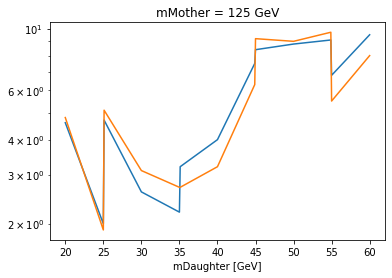

Looks good. Saving this to comb_LHC13_ATLAS_37.json


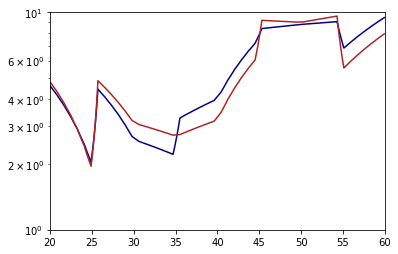

In [2]:
df = pd.DataFrame(
    data={
        "mDaughter1": [20, 25, 25.1, 30, 35, 35.1, 40, 44.9, 45, 50, 54.9, 55, 60],
        "obs": [4.8, 1.9, 5.1, 3.1, 2.7, 2.7, 3.2, 6.3, 9.2, 9, 9.7, 5.5, 8],
        "exp": [4.6, 2, 4.7, 2.6, 2.2, 3.2, 4, 7.5, 8.4, 8.8, 9.1, 6.8, 9.5],
        "mMother": 125,
    }
)

limitFile = implementPairDecayLimit(
    "1803.11145",
    {
        "production": ["ggH", "vbfH"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["gg"],
    },
    "Tab. 2",
    df,
    massResolution={
        "firstDaughter": {"absolute": 1.3, "relative": 0},  # p 5
        "secondDaughter": {"absolute": 6, "relative": 0.3},  # fit to xR in tab 1
        "mother": {
            "absolute": 30,  # guess
            "relative": 0,
        },
    },
    constraints={
        "mother": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [["ggH", "none"], ["vbfH", "none"]]},
            }
        ]
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("gamgam", 1.0)
h2.setDecayWidth("gg", 1.0)
hh.setMass(125)
hm = np.linspace(20, 60)
r = np.linspace(1, 10)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    h2.setMass(mass)
    HP.effectiveCouplingInput(
        hh,
        HP.scaledSMlikeEffCouplings(
            np.sqrt(
                rate
                / (
                    HP.SMHiggs(125).cxn("LHC13", "ggH")
                    + HP.SMHiggs(125).cxn("LHC13", "vbfH")
                )
            )
        ),
    )
    hh.setTotalWidth(0)
    hh.setDecayWidth("h1", "h2", 1.0)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")
plt.show()
